# ELEC-E7851 Computational User Interface Design

# Bandits (07.12.2018)
### Kashyap Todi (www.kashyaptodi.com)

In [1]:
import time
import random
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

## Defining a Bandit

We start by defining a Bandit.

A bandit has $n$ arms.<br/>
Each arm has a reward probability $\theta$.<br/>
When we pull an arm $i$, the bandit returns a reward with corresponding probability $i_\theta$.

In [2]:
class Bandit(object):
    def __init__(self,n,thetas):
        assert len(thetas) == n
        self.n = n
        self.thetas = thetas
        self.best_theta = max(self.thetas)

    def pull_arm(self, i):
        # Pull i-th arm and return reward
        if np.random.random() < self.thetas[i]:
            return 1
        else:
            return 0


Let's create two Bandit instances.

In [3]:
thetas1 = [0.15,0.30,0.60]
bandit1 = Bandit(len(thetas1),thetas1) #Define a 3-armed bandit

thetas2 = [0.15,0.30,0.60,0.4,0.3,0.2,0.1,0.5,0.25]
bandit2 = Bandit(len(thetas2),thetas2) #Define a 9-armed bandit

## Defining a Generic Solver

A generic Bandit solver consists of:
1. bandit: A Bandit object
2. counts: Number of times each arm has been pulled
3. actions: A History of actions taken (arms pulled)
4. regret: Cumulative regret until current time step
5. regrets: A history of cumulative regrets

A solver must specify the steps taken during a single time step (`run_one_step`)

A solver can be run $num\ steps$ times, to calculate the cumulative regret and optionally the estimated $\theta$s.



In [4]:
class Solver(object):
    def __init__(self, bandit):
        """
        bandit (Bandit): the target bandit to solve
        """
        assert isinstance (bandit, Bandit)
        np.random.seed(int(time.time()))
        
        self.bandit = bandit
        
        self.counts = [0] * self.bandit.n
        self.actions = [] # History of actions (list of arms pulled)
        self.regret = 0. # Cumulative regret
        self.regrets = [0.] #History of cumulative regrets
        
    def update_regret(self, i):
        # i: index of selected arm
        self.regret += self.bandit.best_theta - self.bandit.thetas[i]
        self.regrets.append(self.regret)
        
    @property
    def estimated_thetas(self):
        raise NotImplementedError
        
    def run_one_step(self):
        """Return the arm index to take action on."""
        raise NotImplementedError
        
    def run(self, num_steps):
        assert self.bandit is not None
        for _ in range(num_steps):
            i = self.run_one_step()
            
            self.counts[i] += 1
            self.actions.append(i)
            self.update_regret(i)
            
        

## Defining an Experiment
Let us now define an experiment to run the solver for n trials with m iterations each trial.

In [5]:
def run_solver (solver, trials = 20, iterations = 1000):
    regret_history = []
    for trial in range(trials):
        solver.regret = 0
        solver.regrets = []
        solver.run(iterations)
        regret_history.append(solver.regret)
    print(solver.name, np.mean(regret_history), "+/-",np.std(regret_history))

## Implement Solvers

### 1. Explore-Only:
First, let's write a random solver, that randomly explores at every iteration:

In [6]:
class Random(Solver):
    def __init__(self, bandit):
        super(Random, self).__init__(bandit)
        self.name = "Random"
            
    def run_one_step(self):
            i = np.random.randint(0, self.bandit.n) #Pick a random arm
            reward = self.bandit.pull_arm(i) #Pull arm i and get reward
            return i

### 2. Exploit-Only:
Next, let's write a Greedy solver, that exploits a pre-determined arm at every iteration:

In [7]:
class Greedy(Solver):
    def __init__(self, bandit, arm):
        super(Greedy, self).__init__(bandit)
        self.arm = arm # Chosen arm ("best-known")
        self.name = "Greedy"
    
    
    def run_one_step(self):
        reward = self.bandit.pull_arm(self.arm) #Pull arm i and get reward
        return self.arm

 ### 3. $\epsilon$-Greedy:
 
We can explore random arms with a fixed probability ($\epsilon$), while exploiting the best found arm otherwise.
 
After each time step, we obtain reward r for pulling arm i.<br/>
We update the estimated theta for arm i based on the outcome.

In [8]:
class EpsilonGreedy(Solver):
    def __init__(self, bandit, epsilon, init_theta=1.0):
        """
        epsilon (float): the probability to explore
        init_theta (float): We optimistically set initial theta to be 1.0
        """
        super(EpsilonGreedy, self).__init__(bandit)
        assert 0. <= epsilon <= 1.0
        self.epsilon = epsilon
        self.estimates = [init_theta]*self.bandit.n #Optimisistic initialisation
        self.name = "Epsilon-Greedy"
    @property
    def estimated_thetas(self):
        return self.estimates
    
    def run_one_step(self):
        if np.random.random() < self.epsilon:
            #We are going to explore
            i = np.random.randint(0, self.bandit.n) #Pick a random arm
        else:
            #We are going to exploit
            i = max(range(self.bandit.n), key=lambda x: self.estimates[x])

        reward = self.bandit.pull_arm(i) #Pull arm i and get reward
        self.estimates[i] += 1. / (self.counts[i]+1) * (reward - self.estimates[i]) #Update estimate for arm i
        return i

 ### 4. UCB1:
 
The Upper Confident Bound solver prefers arms with stronger potential for optimal value.

At each step, we pick the best arm $i$ to maximise the upper confidence bound

$a_t^{UCB}= argmax_{a\in A} \hat{Q_t}(a) + \hat{U_t}(a)$<br><br>
$\hat{U_t}(a) = \sqrt{\dfrac{2 \log t}{2N_t(a)}}$

In [9]:
class UCB1(Solver): #Upper-confidence bound
    
    def __init__(self, bandit, init_theta=1.0):
        """
        init_theta (float): We optimistically set initial theta to be 1.0
        """
        super(UCB1, self).__init__(bandit)
        self.t = 0
        self.estimates = [init_theta]*self.bandit.n #Optimisistic initialisation
        self.name = "UCB1"
        
    @property
    def estimated_thetas(self):
        return self.estimates
    
    def run_one_step(self):
        self.t += 1
        
        # Pick best one with consideration of upper confidence bounds
        i = max(range(self.bandit.n), key=lambda
                x: self.estimates[x] + np.sqrt(2*np.log(self.t)/(1+self.counts[x])))
        reward = self.bandit.pull_arm(i)
        
        self.estimates[i] += 1. / (self.counts[i]+1) * (reward - self.estimates[i]) #Update estimate for arm i

        return i

 ### 5. Thompson Sampling:
 
The Thompson Sampling solver implements probability matching.

For Bernoulli bandit, Q(a) follows a Beta distribution

By default, $\alpha$ and $\beta$ are set to 1 (50% reward probability).<br>
We can set initial $\alpha$ and $\beta$ based on our prior knowledge of reward probability.<br>

After pulling an arm i, the $\alpha$ and $\beta$ for i is updated.


In [10]:
class ThompsonSampling(Solver):
    def __init__(self, bandit, init_alpha=1, init_beta=1):
        """
        init_a (int): initial value of a in Beta(a, b).
        init_b (int): initial value of b in Beta(a, b).
        """
        super(ThompsonSampling, self).__init__(bandit)

        self._alphas = [init_alpha] * self.bandit.n
        self._betas = [init_beta] * self.bandit.n
        self.name = "Thompson Sampling"

    @property
    def estimated_probas(self):
        return [self._alphas[i] / (self._alphas[i] + self._betas[i]) for i in range(self.bandit.n)]

    def run_one_step(self):
        samples = [np.random.beta(self._alphas[x], self._betas[x]) for x in range(self.bandit.n)]
        i = max(range(self.bandit.n), key=lambda x: samples[x])
        reward = self.bandit.pull_arm(i)

        self._alphas[i] += reward
        self._betas[i] += (1 - reward)

        return i

## Test the solvers

We now test the solvers by running the experiment and printing the mean cumulative regret and standard deviation.

In [11]:
# Select one of the bandit instances
bandit = bandit1

# Instantiate solvers 
random = Random(bandit)
greedy = Greedy(bandit,1)
e_greedy = EpsilonGreedy(bandit,0.1) #Set epsilon = 0.1
ucb1 = UCB1(bandit)
thompson = ThompsonSampling(bandit)

# Run experiment for each solver

for solver in [random, greedy, e_greedy, ucb1, thompson]:
    num_trials = 20
    num_iterations = 1000
    run_solver(solver,num_trials,num_iterations)
    action_count = []
    for arm in range(bandit.n):
        action_count.append(solver.actions.count(arm)/num_trials)
    print("Actions per arm: ",action_count, "\n") #Print number of times each arm was pulled

Random 248.175 +/- 6.776365176110286
Actions per arm:  [328.4, 334.65, 336.95] 

Greedy 300.00000000000557 +/- 5.684341886080802e-14
Actions per arm:  [0.0, 1000.0, 0.0] 

Epsilon-Greedy 30.832499999999982 +/- 28.35696243870271
Actions per arm:  [32.75, 53.65, 913.6] 

UCB1 4.829999999999998 +/- 8.387347614114958
Actions per arm:  [3.4, 11.0, 985.6] 

Thompson Sampling 0.7275 +/- 2.4794392007064823
Actions per arm:  [1.15, 0.7, 998.15] 



## In-class task 1: 
- Modify the bandit instance (add more arms, change $\theta$s.
- Change the target arm for Greedy.
- Change $\epsilon$ for $\epsilon$-Greedy.
- Specify strong prior for Thompson Sampling ( $\alpha$ and $\beta$ ).

Observe and discuss how the results vary.

## In-class task 2:
- For one trial, plot a comparative graph showing cumulative regrets over time for each solver.
- Calculate *cumulative reward* over time for each solver, and construct the plot again.

Discuss how they compare.

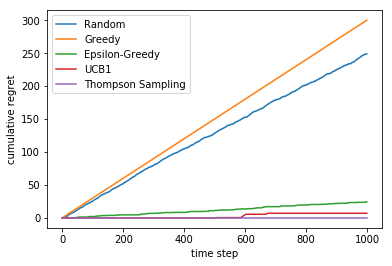

In [12]:
for solver in [random, greedy, e_greedy, ucb1, thompson]:
    plt.plot(solver.regrets, label = solver.name)


plt.legend()
plt.xlabel('time step')
plt.ylabel('cumulative regret')
plt.show()